# Personalize Ranking Example <a class="anchor" id="top"></a>

In this notebook, you will choose a dataset and prepare it for use with Amazon Personalize Batch Recommendations.

1. [Choose a dataset or data source](#source)
1. [Prepare your data](#prepare)
1. [Create dataset groups and the interactions dataset](#group_dataset)
1. [Configure an S3 bucket and an IAM role](#bucket_role)
1. [Import the interactions data](#import)
1. [Create solutions](#solutions)
1. [Create campaigns](#create)
1. [Interact with campaigns](#interact)
1. [Clean up](#cleanup)

## Introduction <a class="anchor" id="intro"></a>

For the most part, the algorithms in Amazon Personalize (called recipes) look to solve different tasks, explained here:

1. **HRNN & HRNN-Metadata** - Recommends items based on previous user interactions with items.
1. **HRNN-Coldstart** - Recommends new items for which interaction data is not yet available.
1. **Personalized-Ranking** - Takes a collection of items and then orders them in probable order of interest using an HRNN-like approach.
1. **SIMS (Similar Items)** - Given one item, recommends other items also interacted with by users.
1. **Popularity-Count** - Recommends the most popular items, if HRNN or HRNN-Metadata do not have an answer - this is returned by default.

No matter the use case, the algorithms all share a base of learning on user-item-interaction data which is defined by 3 core attributes:

1. **UserID** - The user who interacted
1. **ItemID** - The item the user interacted with
1. **Timestamp** - The time at which the interaction occurred

We also support event types and event values defined by:

1. **Event Type** - Categorical label of an event (browse, purchased, rated, etc).
1. **Event Value** - A value corresponding to the event type that occurred. Generally speaking, we look for normalized values between 0 and 1 over the event types. For example, if there are three phases to complete a transaction (clicked, added-to-cart, and purchased), then there would be an event_value for each phase as 0.33, 0.66, and 1.0 respectfully.

The event type and event value fields are additional data which can be used to filter the data sent for training the personalization model. In this particular exercise we will not have an event type or event value. 

## Choose a dataset or data source <a class="anchor" id="source"></a>
[Back to top](#top)

As we mentioned, the user-item-iteraction data is key for getting started with the service. This means we need to look for use cases that generate that kind of data, a few common examples are:

1. Video-on-demand applications
1. E-commerce platforms
1. Social media aggregators / platforms

There are a few guidelines for scoping a problem suitable for Personalize. We recommend the values below as a starting point, although the [official limits](https://docs.aws.amazon.com/personalize/latest/dg/limits.html) lie a little lower.

* Authenticated users
* At least 50 unique users
* At least 100 unique items
* At least 2 dozen interactions for each user 

Most of the time this is easily attainable, and if you are low in one category, you can often make up for it by having a larger number in another category.

Generally speaking your data will not arrive in a perfect form for Personalize, and will take some modification to be structured correctly. This notebook looks to guide you through all of that. 

To begin with, we are going to use the MovieLens 100k dataset. These are records of the movie rating behavior of its users. The data fits our guidelines with a large number for users, items, and interactions.

First, you will download the dataset and unzip it in a new folder using the code below.

Take a look at the data files you have downloaded.

## Prepare your data <a class="anchor" id="prepare"></a>
[Back to top](#top)

The next thing to be done is to load the data and confirm the data is in a good state, then save it to a CSV where it is ready to be used with Amazon Personalize.

To get started, import a collection of Python libraries commonly used in data science.

In [62]:
!git clone https://github.com/catwhiskers/utils.git 

fatal: destination path 'utils' already exists and is not an empty directory.


In [63]:
import os
import sys

sys.path.insert( 0, os.path.abspath("./utils") )

In [64]:
## intrim solution 

!aws s3 cp s3://sagemaker-iris-yianc/athena-result/amz-review-u-i-2015-h/2020/12/12/eed4c9c7-6b78-4e7a-bd2d-9ec9ff328e3d.csv user-item.csv 

download: s3://sagemaker-iris-yianc/athena-result/amz-review-u-i-2015-h/2020/12/12/eed4c9c7-6b78-4e7a-bd2d-9ec9ff328e3d.csv to ./user-item.csv


In [13]:
import time
from time import sleep
import json
from datetime import datetime
import numpy as np
import boto3
import pandas as pd

Next,open the data file and take a look at the first several rows.

In [35]:
data_dir = './'
original_data = pd.read_csv(data_dir + 'user-item.csv', delimiter=',')
# original_data = original_data.rename(columns={0: "user", 1: "item", 2:"rating", 3:"timestamp"})
original_data.head(5)

,product_id,product_category,customer_id,star_rating,timestamp
0,B00RP4XVFU,Digital_Ebook_Purchase,9979839,5,1424649600
1,B00QFPEOQA,Health_&_Personal_Care,9979839,5,1424822400
2,B0052P21K0,Home_Improvement,9979839,5,1424304000
3,B00Q375GVC,Health_&_Personal_Care,9979839,5,1420243200
4,B00TABYZX8,Wireless,9979839,5,1424822400


In [36]:
original_data = original_data.rename(columns={"customer_id": "USER_ID", "product_id": "ITEM_ID", "star_rating":"EVENT_VALUE", 'timestamp':'TIMESTAMP'})
original_data.head()


,ITEM_ID,product_category,USER_ID,EVENT_VALUE,TIMESTAMP
0,B00RP4XVFU,Digital_Ebook_Purchase,9979839,5,1424649600
1,B00QFPEOQA,Health_&_Personal_Care,9979839,5,1424822400
2,B0052P21K0,Home_Improvement,9979839,5,1424304000
3,B00Q375GVC,Health_&_Personal_Care,9979839,5,1420243200
4,B00TABYZX8,Wireless,9979839,5,1424822400


That's better. Now that the data has been successfully loaded into memory, let's extract some additional information. First, calculate some basic statistics from the data.

In [37]:
original_data = original_data.drop(['product_category'], axis=1)

In [38]:
original_data.describe()

,USER_ID,EVENT_VALUE,TIMESTAMP
count,5.592168e+07,5.592168e+07,5.592168e+07
mean,2.895096e+07,4.299292e+00,1.395175e+09
std,1.558575e+07,1.140404e+00,6.204552e+07
min,1.000500e+04,1.000000e+00,8.079264e+08
25%,1.501766e+07,4.000000e+00,1.384992e+09
50%,2.837718e+07,5.000000e+00,1.417997e+09
75%,4.363551e+07,5.000000e+00,1.429402e+09
max,5.309657e+07,5.000000e+00,1.440979e+09


This shows that we have a good range of values for `userID` and `movieID`. Next, it is always a good idea to confirm the data format.

In [7]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55921681 entries, 0 to 55921680
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   ITEM_ID      object
 1   USER_ID      int64 
 2   EVENT_VALUE  int64 
 3   TIMESTAMP    int64 
dtypes: int64(3), object(1)
memory usage: 1.7+ GB


After manipulating the data, always confirm if the data format has changed.

 Amazon Personalize has default column names for users, items, and timestamp. These default column names are `USER_ID`, `ITEM_ID`, AND `TIMESTAMP`. So the final modification to the dataset is to replace the existing column headers with the default headers.

In [9]:

original_data['EVENT_TYPE'] = original_data.apply(lambda x: "rating", axis=1)

original_data.head()

,ITEM_ID,USER_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,B00RP4XVFU,9979839,5,1424649600,rating
1,B00QFPEOQA,9979839,5,1424822400,rating
2,B0052P21K0,9979839,5,1424304000,rating
3,B00Q375GVC,9979839,5,1420243200,rating
4,B00TABYZX8,9979839,5,1424822400,rating


In [32]:
original_data.head()

,ITEM_ID,USER_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,B00RP4XVFU,9979839,5,1424649600,rating
1,B00QFPEOQA,9979839,5,1424822400,rating
2,B0052P21K0,9979839,5,1424304000,rating
3,B00Q375GVC,9979839,5,1420243200,rating
4,B00TABYZX8,9979839,5,1424822400,rating


That's it! At this point the data is ready to go, and we just need to save it as a CSV file.

In [29]:
interactions_filename = "interactions.csv"
original_data.to_csv((data_dir+"/"+interactions_filename), index=False, float_format='%.0f')

In [170]:
products_filename = 'product.csv'
product_data = pd.read_csv(data_dir + products_filename, delimiter=',')
product_data.head(5)

,product_id,product_category,product_title
0,B0059LGBI0,PC,Sony PlayStation (PS) Vita Screen Protector [Military-Grade] RinoGear Premium HD Invisible Clear Shield w/ Lifetime Replacements
1,B000CO7WPK,Automotive,KYB 344055 Excel-G Gas Shock
2,B00OQ01W9I,Wireless,Ravpower Customer Care
3,B00KKEI8ZA,Automotive,KAWELL® 2 Pack 16W LED Work Light ATV 4X4 Off Road Light 6000K
4,B007KPOZK4,Mobile_Apps,STARDOM: THE A-LIST


In [187]:
# product_data = product_data.drop(['product_title'], axis=1)
product_data = product_data.rename(columns={"product_id": "ITEM_ID", "product_id": "ITEM_ID", "star_rating":"EVENT_VALUE", 'timestamp':'TIMESTAMP'})
product_data.head()


,ITEM_ID,product_category
0,B0059LGBI0,PC
1,B000CO7WPK,Automotive
2,B00OQ01W9I,Wireless
3,B00KKEI8ZA,Automotive
4,B007KPOZK4,Mobile_Apps


In [188]:
product_data.describe()

,ITEM_ID,product_category
count,11570547,11570547
unique,11539871,43
top,B00JLXEQE8,Books
freq,6,1672342


This shows that we have a good range of values for `userID` and `movieID`. Next, it is always a good idea to confirm the data format.

In [189]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11570547 entries, 0 to 11570546
Data columns (total 2 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   ITEM_ID           object
 1   product_category  object
dtypes: object(2)
memory usage: 176.6+ MB


After manipulating the data, always confirm if the data format has changed.

 Amazon Personalize has default column names for users, items, and timestamp. These default column names are `USER_ID`, `ITEM_ID`, AND `TIMESTAMP`. So the final modification to the dataset is to replace the existing column headers with the default headers.

That's it! At this point the data is ready to go, and we just need to save it as a CSV file.

In [190]:
items_filename = "items.csv"
product_data.to_csv((data_dir+"/"+items_filename), index=False)

## Create dataset groups and the interactions dataset <a class="anchor" id="group_dataset"></a>
[Back to top](#top)

The highest level of isolation and abstraction with Amazon Personalize is a *dataset group*. Information stored within one of these dataset groups has no impact on any other dataset group or models created from one - they are completely isolated. This allows you to run many experiments and is part of how we keep your models private and fully trained only on your data. 

Before importing the data prepared earlier, there needs to be a dataset group and a dataset added to it that handles the interactions.

Dataset groups can house the following types of information:

* User-item-interactions
* Event streams (real-time interactions)
* User metadata
* Item metadata

Before we create the dataset group and the dataset for our interaction data, let's validate that your environment can communicate successfully with Amazon Personalize.

In [29]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

### Create the dataset group

The following cell will create a new dataset group with the name `personalize-ranking-ml100k`.

In [ ]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "personalize-ranking-amz-review"
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

Before we can use the dataset group, it must be active. This can take a minute or two. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the dataset group every second, up to a maximum of 3 hours.

In [15]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


Now that you have a dataset group, you can create a dataset for the interaction data.

### Create the dataset

First, define a schema to tell Amazon Personalize what type of dataset you are uploading. There are several reserved and mandatory keywords required in the schema, based on the type of dataset. More detailed information can be found in the [documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

Here, you will create a schema for interactions data, which needs the `USER_ID`, `ITEM_ID`, and `TIMESTAMP` fields. These must be defined in the same order in the schema as they appear in the dataset.

In [16]:
interactions_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
          "name": "EVENT_VALUE",
          "type": [
             "float",
             "null"
          ]
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        },
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "p13n-amz-review-ranking",
    schema = json.dumps(interactions_schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:230755935769:schema/p13n-amz-review-ranking",
  "ResponseMetadata": {
    "RequestId": "cad97703-2c9d-47da-a25d-3ea07060d2bc",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Dec 2020 07:07:09 GMT",
      "x-amzn-requestid": "cad97703-2c9d-47da-a25d-3ea07060d2bc",
      "content-length": "89",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [152]:
items_schema = {
  "type": "record",
  "name": "Items",
  "namespace": "com.amazonaws.personalize.schema",
  "fields": [
    {
      "name": "ITEM_ID",
      "type": "string"
    },
    {
      "name": "product_category",
      "type": [
        "null",
        "string"
      ],
      "categorical": True
    }
  ],
  "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "p13n-amz-review-items",
    schema = json.dumps(items_schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:230755935769:schema/p13n-amz-review-items",
  "ResponseMetadata": {
    "RequestId": "8b30132c-4d42-42f0-ad01-f07b5476f284",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 15 Dec 2020 01:53:29 GMT",
      "x-amzn-requestid": "8b30132c-4d42-42f0-ad01-f07b5476f284",
      "content-length": "87",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [178]:
schema_arn

'arn:aws:personalize:us-east-1:230755935769:schema/p13n-amz-review-items'

With a schema created, you can create a dataset within the dataset group. Note, this does not load the data yet. This will happen a few steps later.

In [ ]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "personalize-ranking-amz-review",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

In [ ]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "personalize-ranking-amz-items",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = schema_arn
)

# interactions_dataset_arn = create_dataset_response['datasetArn']
products_dataset_arn = "arn:aws:personalize:us-east-1:230755935769:dataset/personalize-ranking-amz-review/ITEMS"
print(json.dumps(create_dataset_response, indent=2))

In [181]:
items_filename

'items.csv'

In [191]:
interactions_file_path = data_dir  + interactions_filename
items_file_path = data_dir  + items_filename
boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_filename).upload_file(interactions_file_path)
boto3.Session().resource('s3').Bucket(bucket_name).Object(items_filename).upload_file(items_file_path)
interactions_s3DataPath = "s3://"+bucket_name+"/"+interactions_filename
products_s3DataPath = "s3://"+bucket_name+"/"+items_filename
products_s3DataPath, interactions_s3DataPath

('s3://p13n-amz-review-ranking-demo-90409/items.csv',
 's3://p13n-amz-review-ranking-demo-90409/interactions.csv')

In [166]:
products_dataset_arn = "arn:aws:personalize:us-east-1:230755935769:dataset/personalize-ranking-amz-review/ITEMS"

## Configure an S3 bucket and an IAM  role <a class="anchor" id="bucket_role"></a>
[Back to top](#top)

So far, we have downloaded, manipulated, and saved the data onto the Amazon EBS instance attached to instance running this Jupyter notebook. However, Amazon Personalize will need an S3 bucket to act as the source of your data, as well as IAM roles for accessing that bucket. Let's set all of that up.

Use the metadata stored on the instance underlying this Amazon SageMaker notebook, to determine the region it is operating in. If you are using a Jupyter notebook outside of Amazon SageMaker, simply define the region as a string below. The Amazon S3 bucket needs to be in the same region as the Amazon Personalize resources we have been creating so far.

In [18]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-east-1


Amazon S3 bucket names are globally unique. To create a unique bucket name, the code below will append the string `personalizepoc` to your AWS account number. Then it creates a bucket with this name in the region discovered in the previous cell.

In [30]:
s3 = boto3.client('s3')
suffix = str(np.random.uniform())[4:9]
bucket_name = "p13n-amz-review-ranking-demo-"+   suffix        # replace with the name of your S3 bucket
print(bucket_name)
if region != "us-east-1":
    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
else:
    s3.create_bucket(Bucket=bucket_name)

p13n-amz-review-ranking-demo-90409


### Upload data to S3

Now that your Amazon S3 bucket has been created, upload the CSV file of our user-item-interaction data. 

### Set the S3 bucket policy
Amazon Personalize needs to be able to read the contents of your S3 bucket. So add a bucket policy which allows that.

In [50]:
bucket_name

'p13n-amz-review-ranking-demo-90409'

In [49]:
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket_name),
                "arn:aws:s3:::{}/*".format(bucket_name)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': '265245A3115071D6',
  'HostId': 'jaa1BpqTDWGoNGVvzXNJqy5Bv8+Qs1qIO828Xz6FawWQeFUhJaETUmZArWUtASne3xFTiNuP3MY=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'jaa1BpqTDWGoNGVvzXNJqy5Bv8+Qs1qIO828Xz6FawWQeFUhJaETUmZArWUtASne3xFTiNuP3MY=',
   'x-amz-request-id': '265245A3115071D6',
   'date': 'Sat, 12 Dec 2020 07:35:29 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

### Create an IAM role

Amazon Personalize needs the ability to assume roles in AWS in order to have the permissions to execute certain tasks. Let's create an IAM role and attach the required policies to it. The code below attaches very permissive policies; please use more restrictive policies for any production application.

In [44]:
iam = boto3.client("iam")

role_name = "AmzReviewRankingRole"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

# create_role_response = iam.create_role(
#     RoleName = role_name,
#     AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
# )

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::230755935769:role/AmzReviewRankingRole


In [45]:
role_arn="arn:aws:iam::230755935769:role/PersonalizeAmzRole"

## Import the interactions data <a class="anchor" id="import"></a>
[Back to top](#top)

Earlier you created the dataset group and dataset to house your information, so now you will execute an import job that will load the data from the S3 bucket into the Amazon Personalize dataset. 

In [28]:
"s3://{}/{}".format(bucket_name, interactions_filename)

's3://p13n-amz-review-ranking-demo-29886/interactions.csv'

In [51]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "p13n-amz-review-ranking-job-2",
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, interactions_filename)
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:230755935769:dataset-import-job/p13n-amz-review-ranking-job-2",
  "ResponseMetadata": {
    "RequestId": "abc14468-311f-46fa-81d6-f6c0450aa56e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Dec 2020 07:36:06 GMT",
      "x-amzn-requestid": "abc14468-311f-46fa-81d6-f6c0450aa56e",
      "content-length": "117",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


Before we can use the dataset, the import job must be active. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the import job every second, up to a maximum of 3 hours.

Importing the data can take some time, depending on the size of the dataset. In this workshop, the data import job should take around 15 minutes.

In [53]:
%%time

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = dataset_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetImportJob: ACTIVE
CPU times: user 13.3 ms, sys: 350 µs, total: 13.6 ms
Wall time: 1.07 s


In [192]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "p13n-amz-review-ranking-job-items",
    datasetArn = products_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, items_filename)
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:230755935769:dataset-import-job/p13n-amz-review-ranking-job-items",
  "ResponseMetadata": {
    "RequestId": "0b2b8aa4-839b-41db-a5fa-214615e262dd",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 15 Dec 2020 05:50:22 GMT",
      "x-amzn-requestid": "0b2b8aa4-839b-41db-a5fa-214615e262dd",
      "content-length": "121",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


Before we can use the dataset, the import job must be active. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the import job every second, up to a maximum of 3 hours.

Importing the data can take some time, depending on the size of the dataset. In this workshop, the data import job should take around 15 minutes.

In [193]:
%%time

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = dataset_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_P

When the dataset import is active, you are ready to start building models with SIMS, Personalized-Ranking, Popularity-Count, and HRNN. This process will continue in other notebooks. Run the cell below before moving on to store a few values for usage in the next notebooks.

## Create solutions <a class="anchor" id="solutions"></a>
[Back to top](#top)

In this notebook, you will create solutions with the following recipe:

`aws-personalized-ranking`


In Amazon Personalize, a specific variation of an algorithm is called a recipe. Different recipes are suitable for different situations. A trained model is called a solution, and each solution can have many versions that relate to a given volume of data when the model was trained.

To start, we will list all the recipes that are supported. This will allow you to select one and use that to build your model.

In [54]:
personalize.list_recipes()

{'recipes': [{'name': 'aws-hrnn',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2020, 8, 25, 16, 57, 0, 148000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-coldstart',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-coldstart',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2020, 8, 25, 16, 57, 0, 148000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-metadata',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-metadata',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2020, 8, 25, 16, 57, 0, 148000, tzinfo=tzlocal())},
  {'name': 'aws-personalized-ranking',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-personalized-ranking',
   's

### Personalized Ranking

Personalized Ranking is an interesting application of HRNN. Instead of just recommending what is most probable for the user in question, this algorithm takes in a user and a list of items as well. The items are then rendered back in the order of most probable relevance for the user. The use case here is for filtering on genre for example, or when you have a broad collection that you would like better ordered for a particular user.

In [55]:
rerank_recipe_arn = "arn:aws:personalize:::recipe/aws-personalized-ranking"

#### Create the solution

As with the previous solution, start by creating the solution first. Although you provide the dataset ARN in this step, the model is not yet trained. See this as an identifier instead of a trained model.

In [194]:
rerank_create_solution_response = personalize.create_solution(
    name = "p13n-amz-review-ranking-items",
    datasetGroupArn = dataset_group_arn,
    recipeArn = rerank_recipe_arn
)

rerank_solution_arn = rerank_create_solution_response['solutionArn']
print(json.dumps(rerank_create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:us-east-1:230755935769:solution/p13n-amz-review-ranking-items",
  "ResponseMetadata": {
    "RequestId": "56cc0d55-d48f-42f1-b1a7-13b0cd11ff04",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 15 Dec 2020 07:01:56 GMT",
      "x-amzn-requestid": "56cc0d55-d48f-42f1-b1a7-13b0cd11ff04",
      "content-length": "99",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create the solution version

Once you have a solution, you need to create a version in order to complete the model training. The training can take a while to complete, upwards of 25 minutes, and an average of 35 minutes for this recipe with our dataset. Normally, we would use a while loop to poll until the task is completed. However the task would block other cells from executing, and the goal here is to create many models and deploy them quickly. So we will set up the while loop for all of the solutions further down in the notebook. There, you will also find instructions for viewing the progress in the AWS console.

In [195]:
rerank_create_solution_version_response = personalize.create_solution_version(
    solutionArn = rerank_solution_arn
)

In [196]:
rerank_solution_version_arn = rerank_create_solution_version_response['solutionVersionArn']
print(json.dumps(rerank_create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:230755935769:solution/p13n-amz-review-ranking-items/d26cfe11",
  "ResponseMetadata": {
    "RequestId": "43d406ad-703a-4e25-874a-4b0f0baedd0a",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 15 Dec 2020 07:02:01 GMT",
      "x-amzn-requestid": "43d406ad-703a-4e25-874a-4b0f0baedd0a",
      "content-length": "115",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### View solution creation status

As promised, how to view the status updates in the console:

* In another browser tab you should already have the AWS Console up from opening this notebook instance. 
* Switch to that tab and search at the top for the service `Personalize`, then go to that service page. 
* Click `View dataset groups`.
* Click the name of your dataset group, most likely something with POC in the name.
* Click `Solutions and recipes`.
* You will now see a list of all of the solutions you created above,  including a column with the status of the solution versions. Once it is `Active`, your solution is ready to be reviewed. It is also capable of being deployed.

Or simply run the cell below to keep track of the solution version creation status.

In [ ]:
in_progress_solution_versions = [
    rerank_solution_version_arn
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for solution_version_arn in in_progress_solution_versions:
        version_response = personalize.describe_solution_version(
            solutionVersionArn = solution_version_arn
        )
        status = version_response["solutionVersion"]["status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
    
    if len(in_progress_solution_versions) <= 0:
        break
    else:
        print("At least one solution build is still in progress")
        
    time.sleep(60)

At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solutio

At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress


## Create campaigns <a class="anchor" id="create"></a>
[Back to top](#top)

A campaign is a hosted solution version; an endpoint which you can query for recommendations. Pricing is set by estimating throughput capacity (requests from users for personalization per second). When deploying a campaign, you set a minimum throughput per second (TPS) value. This service, like many within AWS, will automatically scale based on demand, but if latency is critical, you may want to provision ahead for larger demand. For this POC and demo, all minimum throughput thresholds are set to 1. For more information, see the [pricing page](https://aws.amazon.com/personalize/pricing/).

Let's start deploying the campaigns.

### Personalized Ranking

Deploy a campaign for your personalized ranking solution version. It can take around 10 minutes to deploy a campaign. Normally, we would use a while loop to poll until the task is completed. However the task would block other cells from executing, and the goal here is to create multiple campaigns. So we will set up the while loop for all of the campaigns further down in the notebook. There, you will also find instructions for viewing the progress in the AWS console.

In [201]:
rerank_create_campaign_response = personalize.create_campaign(
    name = "p13n-amz-review-poc-rerank-items",
    solutionVersionArn = rerank_solution_version_arn,
    minProvisionedTPS = 1
)

rerank_campaign_arn = rerank_create_campaign_response['campaignArn']
print(json.dumps(rerank_create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:us-east-1:230755935769:campaign/p13n-amz-review-poc-rerank-items",
  "ResponseMetadata": {
    "RequestId": "44d85922-20b6-470a-921f-8d0ff48142ed",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Wed, 16 Dec 2020 00:38:39 GMT",
      "x-amzn-requestid": "44d85922-20b6-470a-921f-8d0ff48142ed",
      "content-length": "102",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### View campaign creation status

As promised, how to view the status updates in the console:

* In another browser tab you should already have the AWS Console up from opening this notebook instance. 
* Switch to that tab and search at the top for the service `Personalize`, then go to that service page. 
* Click `View dataset groups`.
* Click the name of your dataset group, most likely something with POC in the name.
* Click `Campaigns`.
* You will now see a list of all of the campaigns you created above, including a column with the status of the campaign. Once it is `Active`, your campaign is ready to be queried.

Or simply run the cell below to keep track of the campaign creation status.

In [202]:
in_progress_campaigns = [
    rerank_campaign_arn
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for campaign_arn in in_progress_campaigns:
        version_response = personalize.describe_campaign(
            campaignArn = campaign_arn
        )
        status = version_response["campaign"]["status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(campaign_arn))
            in_progress_campaigns.remove(campaign_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(campaign_arn))
            in_progress_campaigns.remove(campaign_arn)
    
    if len(in_progress_campaigns) <= 0:
        break
    else:
        print("At least one campaign build is still in progress")
        
    time.sleep(60)

At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
Build succeeded for arn:aws:personalize:us-east-1:230755935769:campaign/p13n-amz-review-poc-rerank-items


## Interact with campaigns <a class="anchor" id="interact"></a>
[Back to top](#top)

Now that all campaigns are deployed and active, we can start to get recommendations via an API call. Each of the campaigns is based on a different recipe, which behave in slightly different ways because they serve different use cases. We will cover each campaign in a different order than used in previous notebooks, in order to deal with the possible complexities in ascending order (i.e. simplest first).

First, let's create a supporting function to help make sense of the results returned by a Personalize campaign. Personalize returns only an `item_id`. This is great for keeping data compact, but it means you need to query a database or lookup table to get a human-readable result for the notebooks. We will create a helper function to return a human-readable result from the MovieLens dataset.

Start by loading in the dataset which we can use for our lookup table.

In [14]:
items_df = pd.read_csv('product.csv')
items_df = items_df.reset_index()

In [15]:
from amz_review import data_proc
# A known good id
print(data_proc.get_product_by_id(product_id="B00KKEI8ZA", items_df=items_df))

['KAWELL® 2 Pack 16W LED Work Light ATV 4X4 Off Road Light 6000K', 'Automotive']


Great! Now we have a way of rendering results. 

### Personalized Ranking

The core use case for personalized ranking is to take a collection of items and to render them in priority or probable order of interest for a user. To demonstrate this, we will need a random user and a random collection of 25 items.

In [28]:
# Convert user to string:

rerank_campaign_arn = "arn:aws:personalize:us-east-1:230755935769:campaign/p13n-amz-review-poc-rerank-items"

In [17]:
master_user="master_user"
master_user_password="master_user_password"
elastic_search_endpoint="elastic_search_endpoint"

In [48]:
from elastic_search import esquery as q
query = "Apparel"
field = "product_category"


rjson = q.query(query, field, elastic_search_endpoint, master_user, master_user_password)
rjson

{'took': 25,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 2.2918203,
  'hits': [{'_index': 'product',
    '_type': 'product',
    '_id': 'UQinUXYBXrWQULoftY3E',
    '_score': 2.2918203,
    '_source': {'product_id': 'B00842PLGY',
     'product_category': 'Apparel',
     'product_title': 'Secret Wishes Sexy Dust Bunny Maid Costume'}},
   {'_index': 'product',
    '_type': 'product',
    '_id': 'JnSnUXYB_l31ckDJuLpu',
    '_score': 2.2918203,
    '_source': {'product_id': 'B00KB614I0',
     'product_category': 'Apparel',
     'product_title': "Aria Collection Women's Sueded Microfleece 2-Piece Pajama Set"}},
   {'_index': 'product',
    '_type': 'product',
    '_id': '4JynUXYBAiVFg570uxGl',
    '_score': 2.2918203,
    '_source': {'product_id': 'B00KQT55XM',
     'product_category': 'Apparel',
     'product_title': "Men's Leather Holster Case for Samsung Galaxy S6 / Edge /

In [49]:
from amz_review import data_proc 


rerank_user = 49240011
all_df = data_proc.get_user_history(rerank_user, original_data, items_df)
all_df.head()

        ITEM_ID   USER_ID  EVENT_VALUE   TIMESTAMP
28   B00IP4FGDO  49240011  5            1426464000
29   B000I62YR8  49240011  5            1380672000
30   B008JC82BA  49240011  4            1377043200
31   B00BN4YBOI  49240011  5            1440547200
32   B001PNHWFC  49240011  5            1424044800
33   B00H128FKM  49240011  5            1426464000
34   B000I6MBH6  49240011  5            1420588800
35   B008OBGY98  49240011  5            1404777600
36   B003STEIYY  49240011  5            1400025600
37   B0046XRLTU  49240011  5            1383696000
38   B008GZ4J76  49240011  4            1382486400
39   0851779719  49240011  5            1426464000
40   B00SBM0M20  49240011  5            1432771200
41   B001FZ5MCU  49240011  5            1420588800
42   B003R0UQ22  49240011  5            1408579200
43   B00COZ4OCY  49240011  5            1440547200
44   B006GFXVUY  49240011  5            1403740800
45   B000059HAN  49240011  5            1405296000
46   B0002DSVTC  49240011  5   

,ITEM_ID,USER_ID,EVENT_VALUE,TIMESTAMP,index,product_id,product_category,product_title
0,B00IP4FGDO,49240011,5,1426464000,2032905,B00IP4FGDO,Health_&_Personal_Care,"Combat Source Kill Max Roach Killing Gel, 60 Grams Pack Of 2"
1,B000I62YR8,49240011,5,1380672000,5172588,B000I62YR8,Health_&_Personal_Care,"Metamucil Fiber Therapy for Regularity, Fiber Supplement, 300 Capsules"
2,B008JC82BA,49240011,4,1377043200,2954392,B008JC82BA,Wireless,"IC ICLOVER 10pcs Stylus Touch Screen Pen iPhone 8/7 Plus iPhone X, for Samsung Galaxy S8 S7 S6 Edge Plus S5 S4, iPad Tablet Sony PSP"
3,B00BN4YBOI,49240011,5,1440547200,1467393,B00BN4YBOI,Digital_Video_Download,Lewis Black: Stark Raving Black
4,B001PNHWFC,49240011,5,1424044800,89761,B001PNHWFC,Kitchen,Ikea Cork Trivet


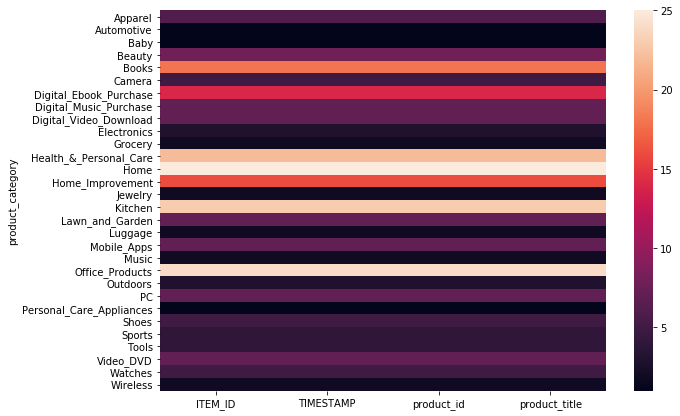

In [50]:
data_proc.plot_heat_map(all_df)

In [52]:
items_from_search = [] 
for h in rjson['hits']['hits']:
    items_from_search.append(h['_source']['product_id'])


get_recommendations_response_rerank = personalize_runtime.get_personalized_ranking(
    campaignArn = rerank_campaign_arn,
    userId = str(rerank_user),
    inputList = items_from_search
)

get_recommendations_response_rerank
    

{'ResponseMetadata': {'RequestId': 'bc8af811-7bc0-4555-9c09-3422f5bcd5af',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/json',
   'date': 'Sun, 27 Dec 2020 14:07:00 GMT',
   'x-amzn-requestid': 'bc8af811-7bc0-4555-9c09-3422f5bcd5af',
   'content-length': '5775',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'personalizedRanking': [{'itemId': 'B00K0DO8VE', 'score': 0.1769225},
  {'itemId': 'B004UM7YUS', 'score': 0.1616409},
  {'itemId': 'B001AISL7K', 'score': 0.0671412},
  {'itemId': 'B000ZFV60I', 'score': 0.0563727},
  {'itemId': 'B00842PLGY', 'score': 0.0533071},
  {'itemId': 'B00CEM4120', 'score': 0.0491168},
  {'itemId': 'B001B6N6SK', 'score': 0.0469053},
  {'itemId': 'B00NQFLDVG', 'score': 0.0463621},
  {'itemId': 'B00CM7KMFW', 'score': 0.0451955},
  {'itemId': 'B001A3Y7C8', 'score': 0.0448921},
  {'itemId': 'B00H9VRB0K', 'score': 0.0445618},
  {'itemId': 'B004Y4WEO8', 'score': 0.0385795},
  {'itemId': 'B00DCCAFCQ', 'score': 0.036043},
  {'itemI

In [53]:
rerank_list = []
for item in items_from_search:
    product = data_proc.get_product_by_id(item, items_df)
    rerank_list.append(product)
rerank_df = pd.DataFrame(rerank_list)
rerank_df

,0,1
0,Secret Wishes Sexy Dust Bunny Maid Costume,Apparel
1,Aria Collection Women's Sueded Microfleece 2-Piece Pajama Set,Apparel
2,Men's Leather Holster Case for Samsung Galaxy S6 / Edge / Active,Apparel
3,"linen newsboy cabbie vintage ivy hat cap, unisex, strech fit (Denim)",Apparel
4,Fresh Tees Brand- Tuxedo With Bowtie T-Shirt Funny Shirts,Apparel
5,Yoga Tank Top - Burnout Racerback Pack of 3,Apparel
6,Jessica McClintock Women's Knit Head Wrap with Rhinestones,Apparel
7,Fownes Women's Cashmere Lined Lambskin Leather Gloves,Apparel
8,Carhartt Men's Sherpa Lined Sandstone Jean Jacket,Apparel
9,Calvin Klein Men's CK One 4 Pocket Jacket,Apparel


In [56]:
all_df[all_df['product_category']==query]

,ITEM_ID,USER_ID,EVENT_VALUE,TIMESTAMP,index,product_id,product_category,product_title
6,B000I6MBH6,49240011,5,1420588800,2796343,B000I6MBH6,Apparel,IZOD Men's American Chino Flat-Front Pant
48,B0012BXA26,49240011,5,1412553600,2402970,B0012BXA26,Apparel,IZOD Men's Saltwater Flat Front Classic Fit Chino Pant
83,B00M59MMBY,49240011,4,1419206400,936165,B00M59MMBY,Apparel,U.S. Polo Assn. Men's Sweater Vest
119,B00KDZC1X6,49240011,5,1412553600,3505132,B00KDZC1X6,Apparel,Brixton - Unisex Hooligan Snap Hat
159,B009CCRK8C,49240011,5,1386028800,924546,B009CCRK8C,Apparel,4pairs 71% Premium Merino Wool Crew Hiking Socks Made in USA People Socks
187,B00HS60LF8,49240011,5,1419206400,5402412,B00HS60LF8,Apparel,Accutron II By Bulova Alpha Collection Men Watch 96a155


In [57]:

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
compare_df = data_proc.compare_personalized_result(rerank_df, get_recommendations_response_rerank, items_df)
compare_df 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


,0,1,Original,Re-Ranked
0,Secret Wishes Sexy Dust Bunny Maid Costume,Apparel,PattyBoutik Women's Floral Lace Off Shoulder Twin Set Top,Apparel
1,Aria Collection Women's Sueded Microfleece 2-Piece Pajama Set,Apparel,"Fedora Hat - Natural Color Straw with Black Band, Natural, One Size",Apparel
2,Men's Leather Holster Case for Samsung Galaxy S6 / Edge / Active,Apparel,Rubie's Costume Full Length Hooded Cape Costume,Apparel
3,"linen newsboy cabbie vintage ivy hat cap, unisex, strech fit (Denim)",Apparel,Caterpillar Men's Trademark Cap,Apparel
4,Fresh Tees Brand- Tuxedo With Bowtie T-Shirt Funny Shirts,Apparel,Secret Wishes Sexy Dust Bunny Maid Costume,Apparel
5,Yoga Tank Top - Burnout Racerback Pack of 3,Apparel,"Beltaway Flat Buckle No Show Adjustable Belt, The Virtually Invisible Belt",Apparel
6,Jessica McClintock Women's Knit Head Wrap with Rhinestones,Apparel,Jabba's Prisoner Princess Leia Costume,Apparel
7,Fownes Women's Cashmere Lined Lambskin Leather Gloves,Apparel,MBJ Womens Comfy Chic Palazzo Lounge Pant - Made in USA,Apparel
8,Carhartt Men's Sherpa Lined Sandstone Jean Jacket,Apparel,Dockers Little Boys' Uniform 8-20 Short Sleeve Pique Polo,Apparel
9,Calvin Klein Men's CK One 4 Pocket Jacket,Apparel,Wigwam Men's El Pine Sock,Apparel


Now build a nice dataframe that shows the input data.

Then make the personalized ranking API call.

Now add the reranked items as a second column to the original dataframe, for a side-by-side comparison.

You can see above how each entry was re-ordered based on the model's understanding of the user. This is a popular task when you have a collection of items to surface a user, a list of promotions for example, or if you are filtering on a category and want to show the most likely good items.

In [58]:
%store original_data

Stored 'original_data' (DataFrame)


In [59]:
%store items_df

Stored 'items_df' (DataFrame)


In [60]:
%store master_user
%store master_user_password
%store elastic_search_endpoint

Stored 'master_user' (str)
Stored 'master_user_password' (str)
Stored 'elastic_search_endpoint' (str)


In [61]:
%store rerank_campaign_arn

Stored 'rerank_campaign_arn' (str)
